# Step 3: Cluster

In [1]:
import os
import gc
import pickle
import joblib
import cloudpickle
import datetime

import numpy as np
import pandas as pd
import dask.dataframe as dd
from dask.diagnostics import ProgressBar

from matplotlib import pyplot as plt
import seaborn as sns

import pdb

In [2]:
# register progress bar for compute calls in dask so we have an estimate of how long task will take
pbar = ProgressBar()
pbar.register()

In [3]:
# inferred int64 types cause a type mismatch (int vs float) error when dask sees a null value
# null values cannot be interpreted as ints
custom_dtypes = {
    "date": "object",
    "serial_number": "object",
    "capacity_bytes": "float32",
    "failure": "float32",
    "smart_1_normalized": "float32",
    "smart_1_raw": "float32",
    "smart_5_normalized": "float32",
    "smart_5_raw": "float32",
    "smart_7_normalized": "float32",
    "smart_7_raw": "float32",
    "smart_10_normalized": "float32",
    "smart_10_raw": "float32",
    "smart_184_normalized": "float32",
    "smart_184_raw": "float32",
    "smart_187_normalized": "float32",
    "smart_187_raw": "float32",
    "smart_188_normalized": "float32",
    "smart_188_raw": "float32",
    "smart_189_normalized": "float32",
    "smart_189_raw": "float32",
    "smart_190_normalized": "float32",
    "smart_190_raw": "float32",
    "smart_193_normalized": "float32",
    "smart_193_raw": "float32",
    "smart_194_normalized": "float32",
    "smart_194_raw": "float32",
    "smart_197_normalized": "float32",
    "smart_197_raw": "float32",
    "smart_198_normalized": "float32",
    "smart_198_raw": "float32",
    "smart_240_normalized": "float32",
    "smart_240_raw": "float32",
    "smart_241_normalized": "float32",
    "smart_241_raw": "float32",
    "smart_242_normalized": "float32",
    "smart_242_raw": "float32"
}

In [4]:
# read all the cleaned seagate data into one dataframe
DATA_DIR = "/home/kachauha/Downloads/data_Q4_2018_clean"
seagate_df = dd.read_csv(os.path.join(DATA_DIR, '*.csv'), dtype=custom_dtypes)

In [5]:
# get the serial numbers for all the failed hard drives
failed_serials = seagate_df[seagate_df['failure']==1]['serial_number'].compute()

[########################################] | 100% Completed | 13.9s


## Collapse Time Dimension

### Method 1: Mean, Std, Len

In [6]:
# collapse time dim, drop cols that are unncessary for train data
seagate_df_grouped = seagate_df.drop(['date', 'failure'], axis=1).groupby('serial_number')

# characterize a time series by simple stats - mean,std,max,min,size,kurtosis
means = seagate_df_grouped.mean()
means = means.rename(columns={col: 'mean_' + col for col in means.columns})

stds = seagate_df_grouped.std(ddof=0)
stds = stds.rename(columns={col: 'std_' + col for col in stds.columns})
stds = stds.fillna(0)    # FIXME: std returns nans even for ddof=0

# maxs = seagate_df_grouped.max()
# maxs = maxs.rename(columns={col: 'max_' + col for col in maxs.columns})

# mins = seagate_df_grouped.min()
# mins = mins.rename(columns={col: 'min_' + col for col in mins.columns})

days = seagate_df_grouped.size().to_frame('days')

In [7]:
# join stats into one df
X_train = means.merge(right=stds, left_index=True, right_index=True)
# X_train = X_train.merge(right=maxs, left_index=True, right_index=True)
# X_train = X_train.merge(right=mins, left_index=True, right_index=True)
X_train = X_train.merge(right=days, left_index=True, right_index=True)

In [18]:
# sanity check - ensure no nans
X_train.isna().any().any().compute()

[########################################] | 100% Completed | 42.1s


False

### Method 2: Exponentially Weighted Fixed Size Window Agg (TODO)

In [8]:
# get ground truth labels
Y_train = X_train.index.isin(failed_serials).compute()

[########################################] | 100% Completed | 44.1s


## Preprocess

In [10]:
from dask_ml.preprocessing import StandardScaler, RobustScaler

In [11]:
std_scaler = StandardScaler()
rob_scaler = RobustScaler()

X_train = std_scaler.fit_transform(X_train)
# X_train = rob_scaler.fit_transform(X_train)

[########################################] | 100% Completed | 43.4s


## Model Saving For Dask

In [12]:
def save_model(model, fname, suffix=None):
    if suffix is None:
        suffix = datetime.datetime.now().strftime("%b_%d_%Y_%H_%M_%S")
    with open(fname + '_' + suffix + '.cpkl', 'wb') as file:
        cloudpickle.dump(model, file)

## Clusters

In [13]:
from sklearn.metrics import confusion_matrix, homogeneity_completeness_v_measure

### Option 1: Dask ML

In [ ]:
from dask_ml.cluster import KMeans, SpectralClustering

In [65]:
# fit two-cluster kmeans
kmeans = KMeans(n_clusters=3, random_state=42, tol=0.00001, max_iter=15)
kmeans.fit(X_train)

# save the model
save_model(kmeans, 'kmeans')

[########################################] | 100% Completed | 40.9s
[########################################] | 100% Completed | 44.1s
[########################################] | 100% Completed | 42.9s
[########################################] | 100% Completed | 43.4s
[########################################] | 100% Completed | 45.5s
[########################################] | 100% Completed | 44.1s
[########################################] | 100% Completed | 41.6s
[########################################] | 100% Completed | 41.3s
[########################################] | 100% Completed | 41.7s
[########################################] | 100% Completed | 47.2s
[########################################] | 100% Completed | 42.3s
[########################################] | 100% Completed | 42.9s
[########################################] | 100% Completed | 41.6s
[########################################] | 100% Completed | 41.6s
[########################################] | 100

[########################################] | 100% Completed | 42.0s
[[ 1338 81118   196]
 [    5   336     0]
 [    0     0     0]]


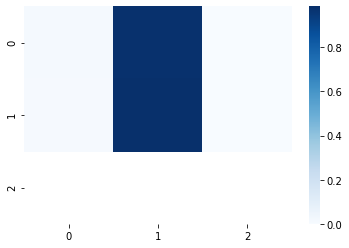

In [66]:
# bring to mem for analysis
kmeans_labels = kmeans.labels_.compute()

# get conf mat
kmeans_conf_mat = confusion_matrix(Y_train, kmeans_labels)
print(kmeans_conf_mat)
sns.heatmap(kmeans_conf_mat / kmeans_conf_mat.sum(axis=1, keepdims=True),
            cmap="Blues")

In [68]:
# fit two-cluster spectral
spectral = SpectralClustering(n_clusters=2, persist_embedding=True, random_state=42)
spectral.fit(X_train.to_dask_array(lengths=True))

# save the model
save_model(spectral, 'spectral')

[########################################] | 100% Completed | 45.7s
[########################################] | 100% Completed | 44.9s
[########################################] | 100% Completed | 47.4s
[########################################] | 100% Completed |  0.3s


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
# bring to mem for analysis
spectral_labels = spectral.labels_.compute()

# get conf mat
spectral_conf_mat = confusion_matrix(Y_train, spectral_labels)
print(spectral_conf_mat)

sns.heatmap(spectral_conf_mat / spectral_conf_mat.sum(axis=1, keepdims=True),
            cmap="Blues")

### Option 2: sklearn with Dask as parallel backend using joblib

In [17]:
from joblib import parallel_backend
# from sklearn.utils import parallel_backend    # this works too for kmeans

from sklearn.cluster import KMeans, SpectralClustering, DBSCAN

In [15]:
# start a local Dask client
from dask.distributed import Client 
client = Client()

In [93]:
with parallel_backend('dask'):
    for k in range(2, 10):
        # find kmeans clusters for current k
        km = skmeans(n_clusters=k, random_state=42)
        km.fit(X_train)
        
        # get metrics for current k
        h, c, v = homogeneity_completeness_v_measure(Y_train, km.labels_)
        print("========================================")
        print("k={}: H={}, C={}, V={}".format(k, h, c, v))
        print("conf mat:")
        print(confusion_matrix(Y_train, km.labels_))

k= 2: H=6.848515299160378e-05, C=1.9800378535589948e-05, V=3.071923405442396e-05
conf mat:
[[81119  1533]
 [  336     5]]
k= 3: H=0.00037707201658545404, C=0.00010120982184295491, V=0.0001595853681000266
conf mat:
[[81118  1338   196]
 [  336     5     0]
 [    0     0     0]]
k= 4: H=0.0004120967325706981, C=0.00010087610130649623, V=0.00016207763451594342
conf mat:
[[81118   908   148   478]
 [  336     4     0     1]
 [    0     0     0     0]
 [    0     0     0     0]]
k= 5: H=0.0004702256468091204, C=0.00011183461948498203, V=0.0001806943690480539
conf mat:
[[81089   906   149   478    30]
 [  336     4     0     1     0]
 [    0     0     0     0     0]
 [    0     0     0     0     0]
 [    0     0     0     0     0]]
k= 6: H=0.00044448513054675645, C=9.974303213248817e-05, V=0.00016292539673169366
conf mat:
[[81089   624   130   326   454    29]
 [  336     3     0     1     1     0]
 [    0     0     0     0     0     0]
 [    0     0     0     0     0     0]
 [    0     0   

In [16]:
with parallel_backend('dask'):
    for k in range(2, 6):
        # find kmeans clusters for current k
        sc = SpectralClustering(n_clusters=k, random_state=42)
        sc.fit(X_train)
        
        # get metrics for current k
        h, c, v = homogeneity_completeness_v_measure(Y_train, sc.labels_)
        print("========================================")
        print("k={}: H={}, C={}, V={}".format(k, h, c, v))
        print("conf mat:")
        print(confusion_matrix(Y_train, sc.labels_))

MemoryError: 

In [25]:
from sklearn.neighbors import DistanceMetric
man = DistanceMetric.get_metric('manhattan')
X_train.index.head()

Index(['6VDHZ9H9', '6VDHZAKY', '6VDHZATY', '6VDHZAXD', '6VDHZB48'], dtype='object', name='serial_number')

In [36]:
foo = X_train.loc['6VDHZAXD', :].compute()
# bar = X_train.loc['6VDHZATY', :].compute()
import scipy
scipy.spatial.distance.cityblock(foo, bar)

38.522346242013505

In [39]:
with parallel_backend('dask'):
    for epsilon in range(1, 6):
        # find kmeans clusters for current k
        db = DBSCAN(metric='manhattan', eps=epsilon)
        db.fit(X_train)
        
        # get metrics for current k
        h, c, v = homogeneity_completeness_v_measure(Y_train, db.labels_)
        print("========================================")
        print("e={}: H={}, C={}, V={}".format(epsilon, h, c, v))
        print("conf mat:")
        print(confusion_matrix(Y_train, db.labels_))

e=1: H=0.0040969275756273325, C=0.0005331403538892181, V=0.0009435012404910959
conf mat:
[[    0     0     0 ...     0     0     0]
 [80478     5    11 ...     5     6     4]
 [  341     0     0 ...     0     0     0]
 ...
 [    0     0     0 ...     0     0     0]
 [    0     0     0 ...     0     0     0]
 [    0     0     0 ...     0     0     0]]
e=2: H=0.1669530204593021, C=0.0017809033841935226, V=0.00352421365383619
conf mat:
[[    0     0     0 ...     0     0     0]
 [26300 13254   119 ...     5     3     3]
 [  337     1     0 ...     0     0     0]
 ...
 [    0     0     0 ...     0     0     0]
 [    0     0     0 ...     0     0     0]
 [    0     0     0 ...     0     0     0]]
e=3: H=0.32776595457007096, C=0.004098996279768483, V=0.008096735885950135
conf mat:
[[    0     0     0 ...     0     0     0]
 [ 8132 16991    21 ...    21     5     5]
 [  331     4     0 ...     0     0     0]
 ...
 [    0     0     0 ...     0     0     0]
 [    0     0     0 ...     0     0  